# CS 583 Lecture 18: Chord Recognition





 

### Utility Code

In [1]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal

from scipy.signal import find_peaks, windows

%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)  

# normalize a signal so that its max = 1.0

def normalize(x):
    return x / max(x)


path = "/Users/waynesnyder/Documents/Teaching/CS583/Audio Files/"
    

### Creating Audio Signals

In [2]:
def makeSignal(S=[(440,1,0)], A = None, duration=1.0,sr=SR):
    X = np.zeros(int(sr*duration)) 
    T = np.arange(int(sr*duration))
    for (f,amp,phi) in S:         
        X +=  amp * np.sin( 2 * np.pi * f * T / sr + phi )
    X / max(X)         # normalize to amplitude 1.0
    if(A == None):
        return  X       
    else:
        return  A * X    

In [3]:
# get signal array and sample rate from a local audio file, will resample to 
#     default SR of 22050

import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=None):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if((sr == None) or (fileSR == sr)):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 

# write signal array out to a file in your local directory (or to complete path name)

def writeSignal(name,data,sr=SR):
    sf.write(name,data,sr)
    

In [4]:
import contextlib
import wave
import array

# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = array.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(fname, X):
    X = [clip(x) for x in X]
    params = [1,2, SR , len(X), "NONE", None]
    data = array.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")



### Two functions for displaying waveforms

In [5]:
# Display 


def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()
    
# test

# f = 10
# X = makeSignal([(10,1,0)])
# displaySignal(X,gridlines=True)

# displaySignal(X,x_units="Samples")

# displaySignal(X,x_units="Milliseconds")


In [6]:
# display the waveform

def displaySignal2(x,sr=SR,title='Signal X',):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.ylim([-1.1,1.1])           # if you want the full range -1 .. 1, else will adapt to signal
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k') # if you want a 0 line
    #plt.grid()                    # if you want gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show()
    
# X = readSignal(k + "trumpet_A4_1_forte_normal.wav")

# displaySignal(X)

### Fast Fourier Transform

The following returns the real spectrum of a signal (amplitude only, no phase) as an array of floats of length $\lfloor N/2\rfloor + 1$ for frequencies 0, f, 2f, ..., up to the Nyquist limit (half the sample rate). 

In [7]:
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

# test

# X = makeSignal(S=[(220,0.5,0),(440,0.3,0),(880,0.2,0),(1100,0.1,0),],duration = 0.19)

# S = realFFT(X)

# print("window frequency", round4(1/0.19))

# print("220 =",220/(1/0.19), "*", round4(1/0.19))
# print()

# for i in range(35,50):
#     print("S["+str(i)+"]:",S[i])

# plt.figure(figsize=(12,6))
# plt.plot(S)
# plt.show()

In [8]:
# We can also return a list of triples of form  [f, A, phi] for each frequency
# f detected by the transform, however, note that, due to floating-point error, 
# you will get extremely small values instead of 0.0 for most of the frequencies; 
# therefore allow the option of filtering out these values using np.isclose(...)
    
def spectrumFFT(X,filterZeros=True):
    R =  np.fft.rfft(X)
    if(filterZeros):
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) 
                                if not np.isclose(2.0 * np.absolute(R[k])/len(X),0.0) ]) 
    else:
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) ]) 

# test
    
# T = np.arange(SR*0.1)    # duration = 0.1 sec
# SR = 22050
# X = 10000 * np.sin( 2 * np.pi * 1000 * T / SR )
# X += 5000 * np.sin( 2 * np.pi * 3000 * T / SR )
# X += 2500 * np.sin( 2 * np.pi * 5000 * T / SR )

# print(round4(spectrumFFT(X)))
# print()
# S = spectrumFFT(X,False)
# print(round4(S[:5]))
# print()
# print(round4(S[98:104]))
# print()
# print(round4(S[-5:]))

### Inverse FFT

In [9]:
# To create a signal of N samples, must input a spectrum array
# of length N/2 + 1 amplitudes, with the kth frequency bin
# representing the amplitude of frequency k*(SR/N)

def realIFFT(S,A=None):
    S = np.array(S)
    lenX = 2*(len(S)-1)
    complex_S = lenX / 2 * -1.j * S
    X = np.fft.irfft(complex_S)
    if(A == None):
        return X
    else:
        return A * X / max(X)

# test

# S = np.zeros(22050)
# S[220] = 1.0
# S[440] = 0.5
# S[880] = 0.25
# S[1760] = 0.125
# X = realIFFT(S)
# plt.plot(X[:1000])
# plt.show()

# Audio(X,rate=SR)

###  Displaying Instantaneous Spectra

Matplotlib has a useful function to display a spectrum for the whole signal; by giving it
a short "window" you can get the same information contained in one column of the spectrogram:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 


In [10]:
# display the spectrum:   xscale (frequency) can be 'linear' or 'log',
#     and yscale can be 'linear' or 'dB' (essentially log)

def displaySpectrum(X,sr=SR,title='Spectrum of X',xscale='linear',yscale='dB'):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.magnitude_spectrum(X,sr,scale=yscale)
    if(xscale == 'linear'):
        plt.xlabel('Frequency (linear)')
    else:    
        plt.xlabel('Frequency (log)')
    if(yscale == 'linear'):
        plt.ylabel('Magnitude (linear)')
    else:    
        plt.ylabel('Magnitude (dB)')
    plt.xscale(xscale)
    plt.show()
    
    
# Example: Create a signal with a simple spectrum

X_trumpet = readSignal(path + "trumpet_A4_1_forte_normal.wav")

# displaySignal(X,title="Signal X: Trumpet playing note A4 = 440 Hz")

X_trumpet_01 = X_trumpet[11025:16537]

# displaySignal(X1,title="Signal X1:  Signal X from 0.5 - 0.75 secs")

# # display the spectrum   scale is 'linear' or 'dB'
    
displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01", xscale='linear', yscale='linear')

displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='linear', yscale='dB')

displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='log', yscale='linear')

displaySpectrum(X_trumpet_01,title="Instantaneous Spectrum of X_trumpet_01",xscale='log', yscale='dB')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/waynesnyder/Documents/Teaching/CS583/Audio Files/trumpet_A4_1_forte_normal.wav'

### Displaying Spectrograms

We can use `librosa.display.specshow` to show spectrograms, which are heatmaps of
spectra over top. Various parameters can be set, including:

    y_axis :   'linear', 'log', 'mel'

    fmin, fmax :  frequency bounds for the mel frequency spectrogram; defaults are fmin=0 and fmax=SR/2 (Nyquist limit)
    
In addition, the `librosa.stft` function takes parameters

    n_fft :    length of the analysis window in samples; defaults to 2048
    
    hop_length : how many samples the window is moved forward for every spectrum; defaults to n_fft / 4

The following is produces a linear scale on the frequency (Y) axis; notice that the typical linear spacing of harmonics (f, 2f, 3f, 4f, etc.) is shown clearly, and correspond to the instantaneous spectrum with a linear frequency scale shown above. 

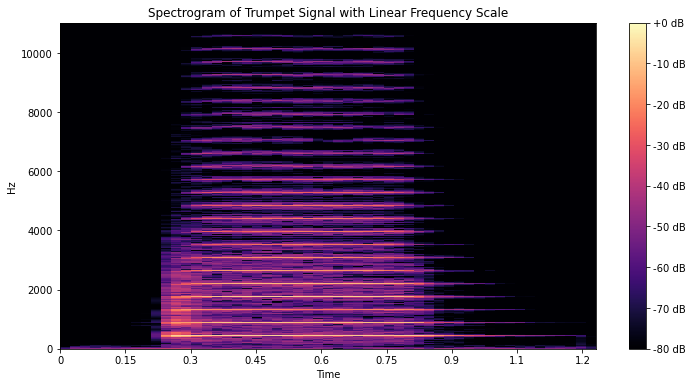

In [11]:
# display the spectrogram

S = np.abs(librosa.stft(X_trumpet))                    # calculate the 2D spectrogram
Sdb = librosa.amplitude_to_db(S, ref=np.max)   # will show power spectrum in heatmap

plt.figure(figsize=(12,6))
plt.title("Spectrogram of Trumpet Signal with Linear Frequency Scale")
librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.show()

Now we change the frequency scale to a log scale, and we can see that the linear sequence of harmonics gets closer and closer together, just as they do on the log scale spectrum above, and, in fact, on a piano keyboard. 

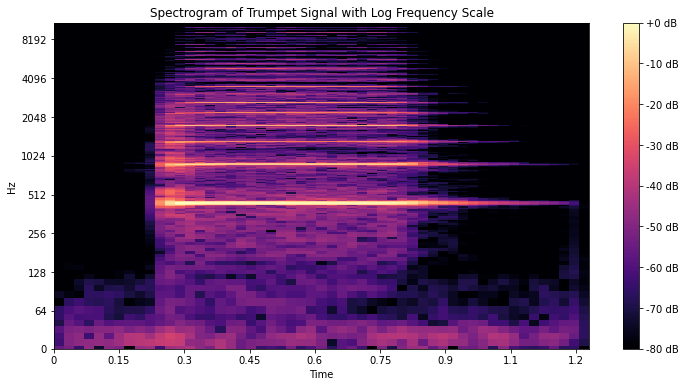

In [12]:
S = np.abs(librosa.stft(X_trumpet))                    # calculate the 2D spectrogram
Sdb = librosa.amplitude_to_db(S, ref=np.max)   # will show power spectrum in heatmap

plt.figure(figsize=(12,6))
plt.title("Spectrogram of Trumpet Signal with Log Frequency Scale")
librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Filterbanks, Mel Scale, Spectrum, and Spectrogram

We can think of the FFT as a sequence of *filters* that isolate the energy in certain frequency bands,
according to the sequence of frequencies 0, f, 2f, etc. up to the Nyquist Limit.  The general approach is often called a *filter bank*, and algorithms can be written that determine the energy at frequencies in different bands than the FFT.

One of the most common approaches (other than the FFT) in Music Information Retrieval uses a sequence of frequency bands that correspond more closely to the logarithmic scale of frequencies in Western music notation and the piano keyboard. 

The Mel Scale is based on research from almost a century ago that pitch (human perception of the frequency of a tone) is not the same as the
frequency as determined by physical measurements or by an algorithm. 

This is a modification of the log scale, according to the following formula:

$$m\ =\ 2595\cdot \text{log}_{10}\bigl ( 1 + {f\over 700} \bigr )$$

and can be graphed as follows:

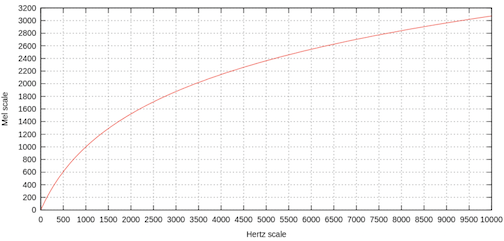

A *mel scale* is used to give a closer approximation to human perception of musical pitch, just as the power spectrum is used to give a closer approximation to loudness. Neither is perfectly accurate, as many, many factors influence the psycho-acoustic perception of musical signals, but they are the best possible approximations (at present). 

The range of the mel scale can be set with `fmin` (defaults to 0) to `fmax` (defaults to SR/2, the Nyquist limit), but can be set lower. 

The parameter `n_mels` (defaulting to 128) gives the number of frequency bins in this range, according to the mel scale. 



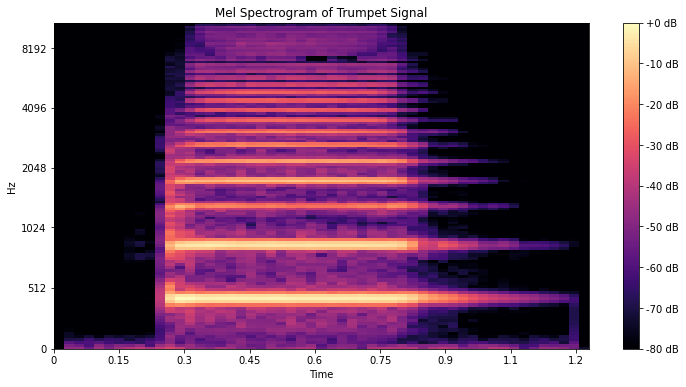

In [13]:
mel_spect = librosa.feature.melspectrogram(y=X_trumpet, sr=SR, n_fft=1024, hop_length=512)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spect, y_axis='mel',  x_axis='time');
plt.title('Mel Spectrogram of Trumpet Signal');
plt.colorbar(format='%+2.0f dB');

Notice in the next spectrogram that the maximum frequency has been set to 4200 (approximately the highest frequency on the piano keyboard) and there are only 64 mel frequency bands. 

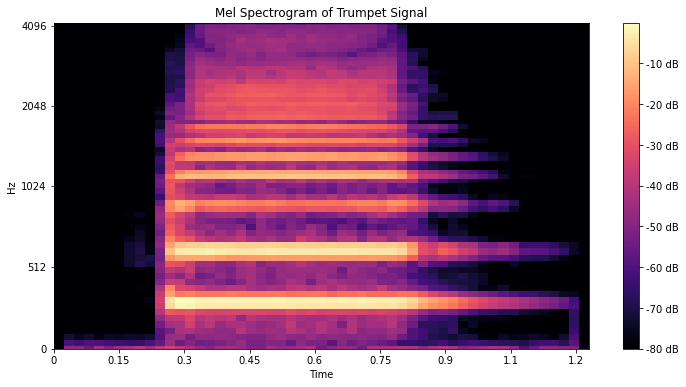

In [14]:
mel_spect = librosa.feature.melspectrogram(y=X_trumpet, sr=SR, n_fft=1024, hop_length=512,n_mels=64)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spect, y_axis='mel', fmax=4200, x_axis='time');
plt.title('Mel Spectrogram of Trumpet Signal');
plt.colorbar(format='%+2.0f dB');

In [15]:
# Amplitude-based onset detection

def AmplitudeBasedOnsets(X,
                         window_size=512,    # width of the analysis window, in samples
                         hop_length=128,     # how far to move the window each time (could also called "hop_length")
                         scale=10,           # scaling factor for log transformation
                                             # Peak picking parameters:  
                         height=None,        # minimum height (we called this threshold in hw02)          
                         prominence=None,    # relative height compared with nearby peaks; see lecture for details
                         distance=None,      # minimum distance between peaks (to avoid multiple peaks at same onset)
                         displayOnsets=True, # show peaks and onsets
                         displayAll=False):  # To print out displays of various signals
    
    N = len(X)
    
    # Normalize amplitude of X so maximum is 1.0
    
    X = X / max(X)     
    
    # Create the energy envelope by using the sliding window technique to calculate the energy
    # in each window and storing it in a numpy array X_energy. The energy in a window is the mean 
    # of the squared samples. 
    
    # Hints:  Easiest is probably to create empty list and append the energy measurements in 
    # a for loop, then convert to numpy array at end. You should end up with (N // hop_length) - 1
    # values in the array; don't worry about it if the last window is not full size. 
    # Could also do with a list comprehension. 

    num_windows = (N // hop_length) - 1

    window_locations = hop_length * np.arange(num_windows)
    
    # The energy in a window is the mean of the squared samples
    
    def energy(X):
        return (X @ X) / len(X)

    X_energy = np.array( [ energy( X[ w : (w+window_size)] ) for w in window_locations ] )

#    # With a Python list:
#     X_energy = []
#     for w in window_locations:
#         e = energy( X[ w : (w+window_size)] )
#         X_energy.append(e)
    
#     X_energy = np.array(X_energy)
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Signal")
        plt.plot(X_energy)
        plt.show()

    # take the log with scaling factor:   np.log(1.0 + scale * X_energy)
    # if scale = None, do nothing

    if(scale == None):
        X_energy_log = X_energy
    else:
        X_energy_log = np.log(1 + scale*X_energy)

    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Log X Energy Signal with scale factor "+str(scale))
        plt.plot(X_energy_log)
        plt.show()

    # Calculate the novelty function (first difference) using np.diff(...)
    # Watch out:  np.diff(...) changes the array IN PLACE, so make a copy beforehand if you want
    # (debugging is easier if you have all the successive arrays)
    
    # Optional: add 0 at beginning so have exactly the same number of values as X_energy
    
    X_energy_log = np.concatenate([[0],X_energy_log])    

    # Take the discrete differential; watch out, diff transforms array in place

    X_energy_novelty = np.diff(list(X_energy_log)) 
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Novelty")
        plt.plot(X_energy_novelty)
        plt.show()
        
    # Now perform half-wave recification by setting all values < 0 to 0. 

    X_energy_novelty_rectified = np.maximum(X_energy_novelty,np.zeros(len(X_energy_novelty)))  
    
    # normalize to 1.0
    
    X_energy_novelty_rectified = X_energy_novelty_rectified / max(X_energy_novelty_rectified)
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Rectified X Energy Novelty")
        plt.plot(X_energy_novelty_rectified)
        plt.show()

    # peak picking using parameters from the argument list: height, prominence, and distance

    peaks,_ = find_peaks(X_energy_novelty_rectified,height=height,prominence=prominence,distance=distance)   
    
    if(displayOnsets or displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Picking Peaks")
        plt.plot(peaks, X_energy_novelty_rectified[peaks], "or")
        plt.plot(X_energy_novelty_rectified)
        plt.show()
    
    # peaks is a list of indices in X_energy_novelty_rectified where peaks were identified; you need to
    # convert from indices in X_energy_novelty_rectified (one value for each sliding window) to sample numbers in X.
    # Important: calculate the location from the MIDDLE of the window.  
    
    onsets = peaks*hop_length + window_size//2

    if(displayOnsets or displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(X)  
        for k in range(len(onsets)):
            plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
        plt.show()
    
    clicks = librosa.clicks(times=onsets/SR, sr=SR, hop_length=hop_length, length=len(X))
    
    return (onsets,clicks)





### Ok, on to new material....

### Example: Beatles' Let It Be

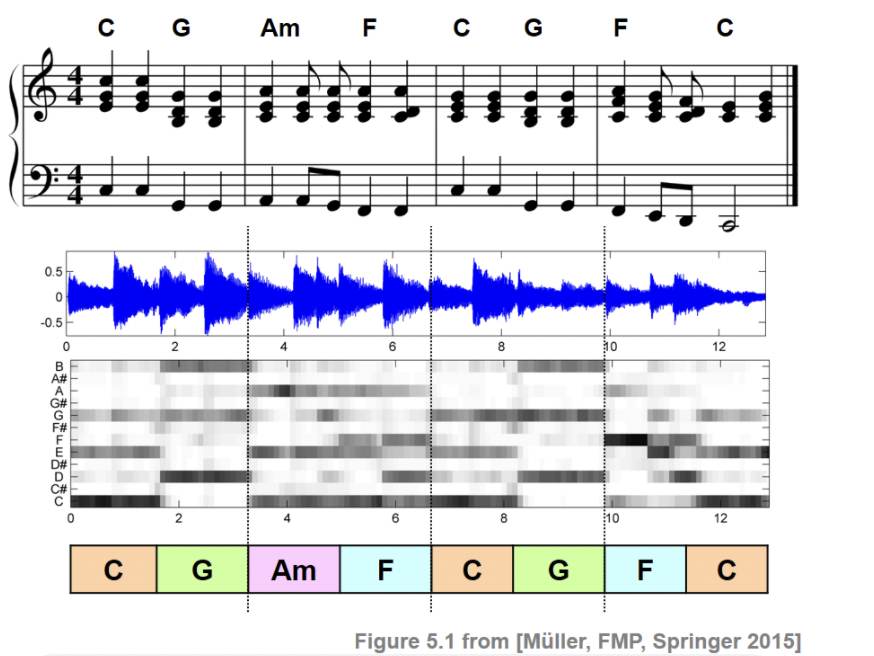

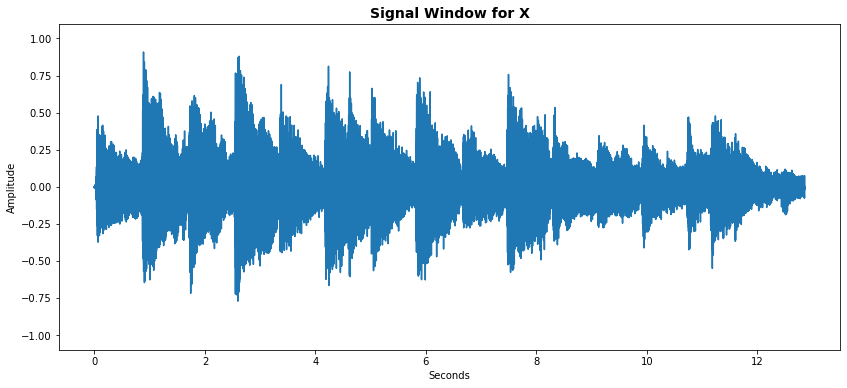

In [16]:
X = readSignal(path + "Let It Be.Beatles_01.wav")
displaySignal(X)
Audio(X,rate=SR)

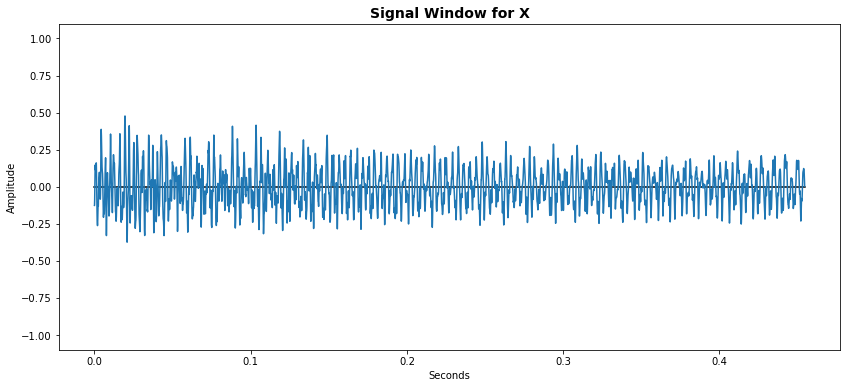

In [17]:
X1 = X[1000:SR//2]

displaySignal(X1)
Audio((X1),rate=SR)


Note	Chroma Energy
C 	 1.0
C# 	 0.19431491
D 	 0.053309113
Eb 	 0.13073488
E 	 0.58523566
F 	 0.29632467
F# 	 0.16626842
G 	 0.33353126
Ab 	 0.09398647
A 	 0.014386762
Bb 	 0.028121196
B 	 0.30417427


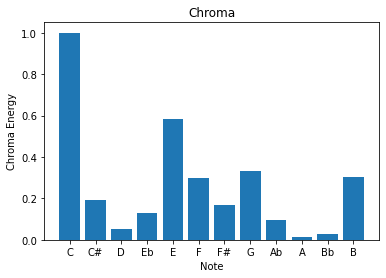

In [48]:
# returns chroma as a numpy array of length 12

note_names = np.array( ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'] )

def get_chroma(x,sr=SR,window_size=4096):
#     # power spectrum
#     c1 = librosa.feature.chroma_stft(y=x, sr=sr,n_fft=window_size,hop_length=len(x)+1)
#     # magnitude spectrum
#     S = np.abs(librosa.stft(x))
#     c2 = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    # Use a pre-computed power spectrogram 
    S = np.abs(librosa.stft(x, n_fft=window_size))**2
    c = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    return (c.T)[0]

c = get_chroma(X1)

print("\nNote\tChroma Energy")
for k in range(12):
    print(note_names[k],"\t", c[k])

plt.title("Chroma")
x = note_names
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, c)
plt.xlabel("Note")
plt.ylabel("Chroma Energy")
plt.xticks(x_pos, x)
plt.show()



In [19]:
chord_names = np.array( ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#',
       'G', 'Ab', 'A', 'Bb', 'B','Cm', 'C#m', 'Dm', 'Ebm', 'Em', 'Fm', 'F#m',
       'Gm', 'Abm', 'Am', 'Bbm', 'Bm'] )

In [20]:
# Make the chord templates for 12 major and 12 minor triads. (from Muller's book)

def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    num_chord = 24
    if nonchord:
        num_chord = 25
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
    return chord_templates

chord_templates = generate_chord_templates()

print("Chord\t Template")
for k in range(len(chord_names)):
    print(chord_names[k],"\t", chord_templates[:,k] )

Chord	 Template
C 	 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
C# 	 [0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
D 	 [0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Eb 	 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
E 	 [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
F 	 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
F# 	 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
G 	 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Ab 	 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
A 	 [0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Bb 	 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
B 	 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
Cm 	 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
C#m 	 [0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
Dm 	 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
Ebm 	 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
Em 	 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
Fm 	 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
F#m 	 [0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Gm 	 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
Abm 	 [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
Am 	 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
Bbm 	 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0

In [21]:
def distance(chroma,template,kind='L2'):      # default is L2 norm
    if(kind == 'L1'):
        return np.sum(np.abs(chroma-template))
    elif(kind == 'L2'):
        return (np.sum((chroma-template)**2))**0.5
    elif(kind == 'CD'):                     # Correlation Distance:  1 + correlation
        s = np.std(chroma)                       # must account for inputs with all 0's
        sn = np.std(template)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((chroma - np.mean(chroma)) @ (template - np.mean(template))) / (len(chroma) * s * sn))              
    else:
        return None

Chroma [1.         0.19431491 0.05330911 0.13073488 0.58523566 0.29632467
 0.16626842 0.33353126 0.09398647 0.01438676 0.0281212  0.30417427] 



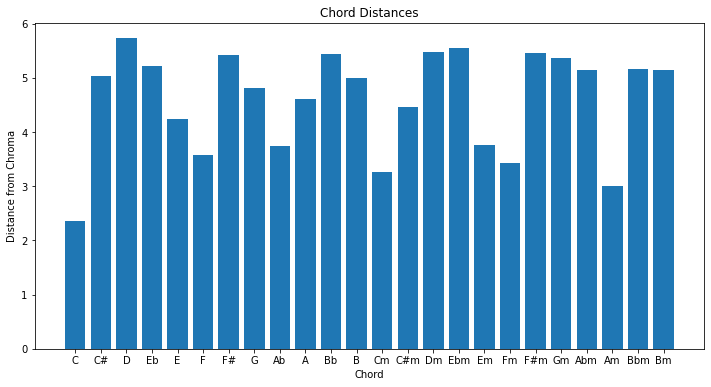


Closest template:  C with distance 2.3629


In [64]:
# apply distance function to chroma and all possible chords, and print array of 24 distances


def apply_chord_templates(chroma,dist="L2",chord_names=chord_names,chord_templates=chord_templates, display=True):
#     if(display):
#         print("Chord\t Score")
    n = 0
    min_score = 1000000
    scores = []
    for k in range(len(chord_names)):
        s = distance(chroma, chord_templates[:,k],kind=dist)
        scores.append(s)
#         if(display):
#             print( chord_names[k], "\t", s )
        if(s < min_score):
            n = k
            min_score = s
    if(display):
        plt.figure(figsize=(12,6))
        plt.title("Chord Distances")
        x = chord_names
        x_pos = [i for i, _ in enumerate(x)]
        plt.bar(x_pos, scores)
        plt.xlabel("Chord")
        plt.ylabel("Distance from Chroma")
        plt.xticks(x_pos, x)
        plt.show()

        print("\nClosest template: ",chord_names[n], "with distance", round4(min_score))
        
    return (chord_names[n],min_score)

ch = get_chroma(X1)

print("Chroma", ch,"\n")

(_,_) = apply_chord_templates(ch,dist="L1")



#### Now let's add beats!

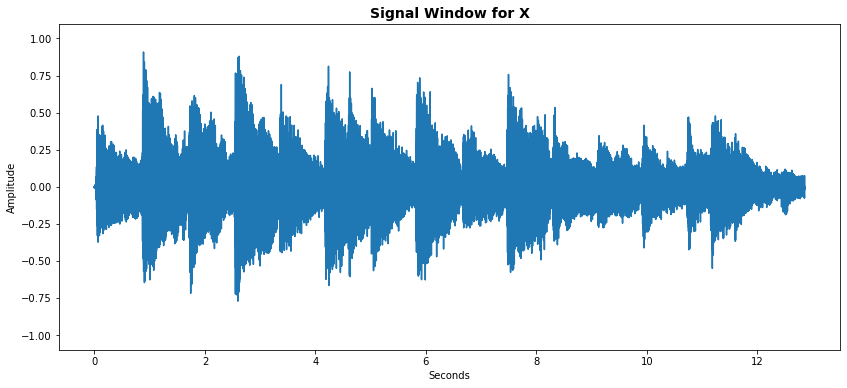

In [23]:
X = readSignal(path + "Let It Be.Beatles_01.wav")
displaySignal(X)
Audio(X,rate=SR)

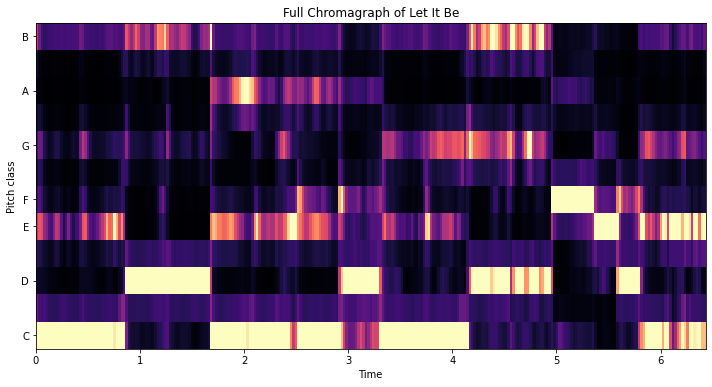

In [24]:
S = np.abs(librosa.stft(X, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=SR)

plt.figure(figsize=(12,6))
plt.title("Full Chromagraph of Let It Be")
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.show()



In [37]:
18432//2

9216


 Librosa Beat Tracing BPM: 71.77734375


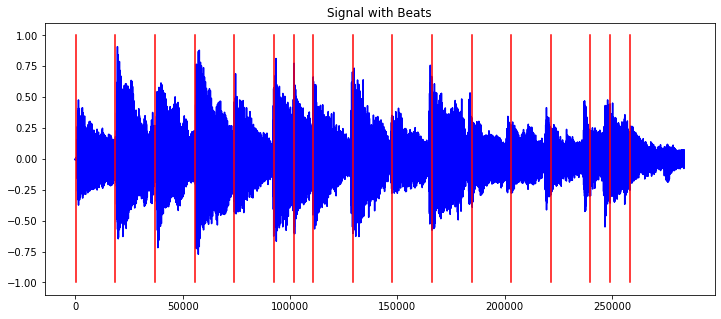

In [61]:
tempo, beats = librosa.beat.beat_track(y=X, sr=SR, hop_length=2048)
print("\n Librosa Beat Tracing BPM:",tempo)    


beats = np.array([     0,  18432,  36864,  55296,  73728,  92160, 101376, 110592, 129024,
       147456, 165888, 184320, 202752, 221184, 239616,248832, 258048])

delay = 200

beats += delay


# beats = np.array([ 9216 * k for k in range(30) ])

plt.figure(figsize=(12,5))
plt.title("Signal with Beats")
plt.plot(X,color='b')
for k in range(len(beats)):
    plt.plot([beats[k],beats[k]],[-1,1],color='r')    
plt.show()

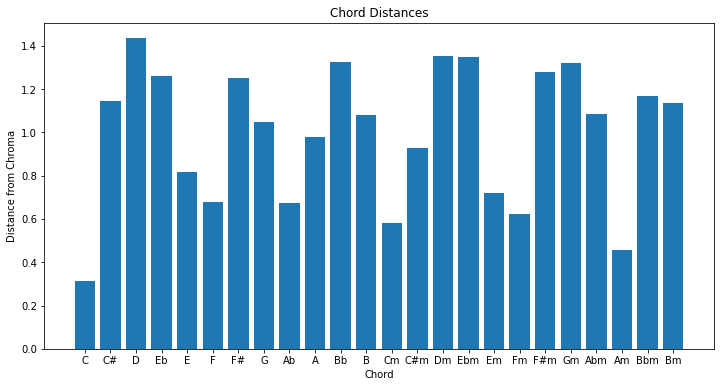


Closest template:  C with distance 0.3116


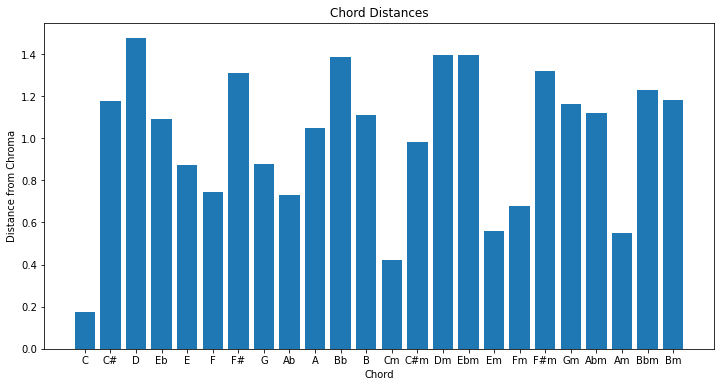


Closest template:  C with distance 0.1738


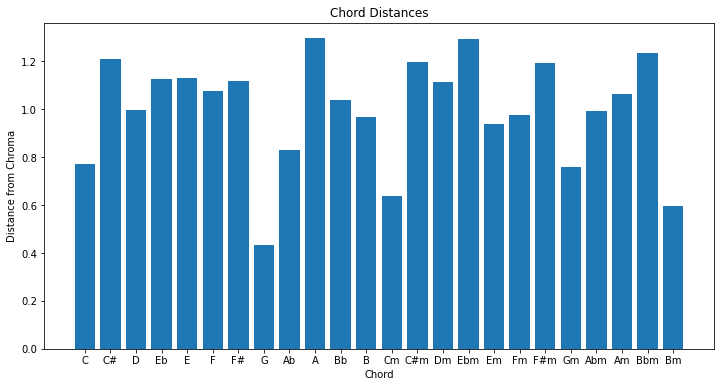


Closest template:  G with distance 0.4319


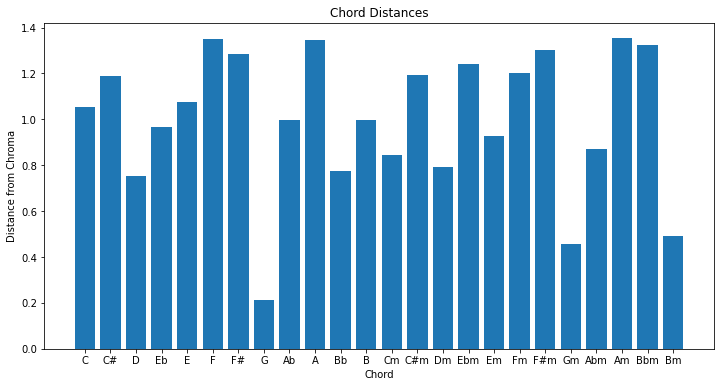


Closest template:  G with distance 0.212


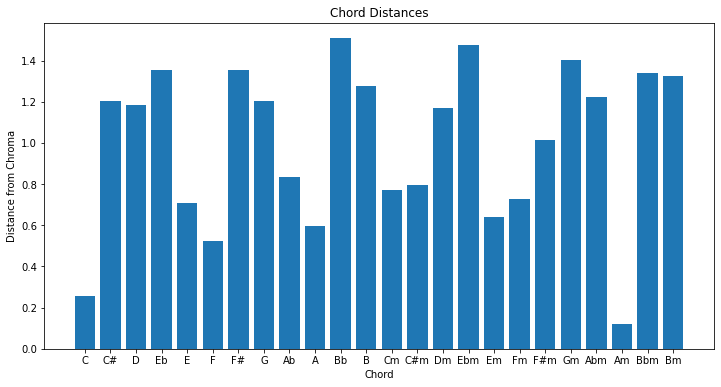


Closest template:  Am with distance 0.1189


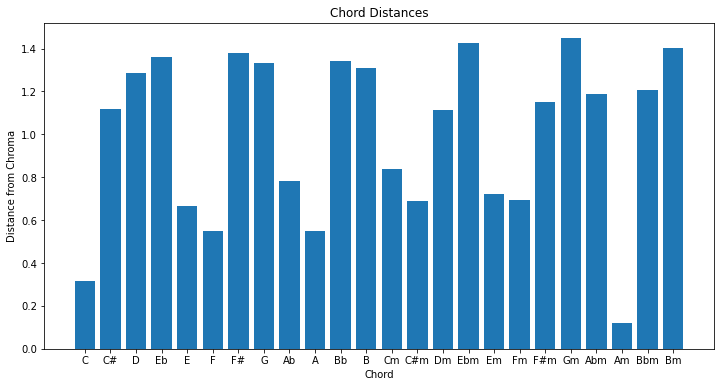


Closest template:  Am with distance 0.1216


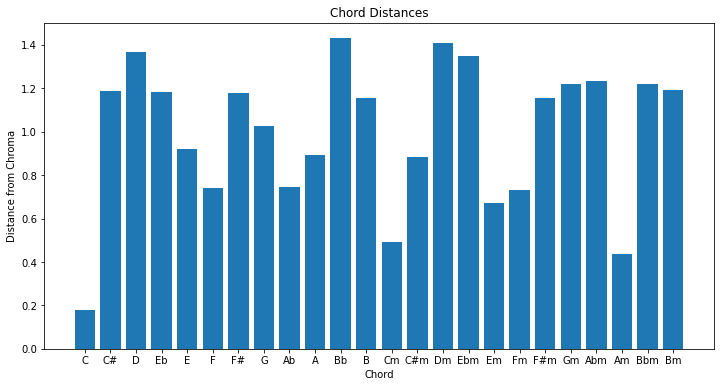


Closest template:  C with distance 0.1785


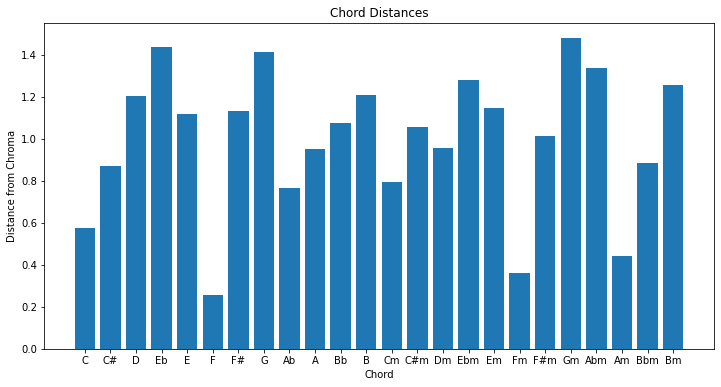


Closest template:  F with distance 0.2561


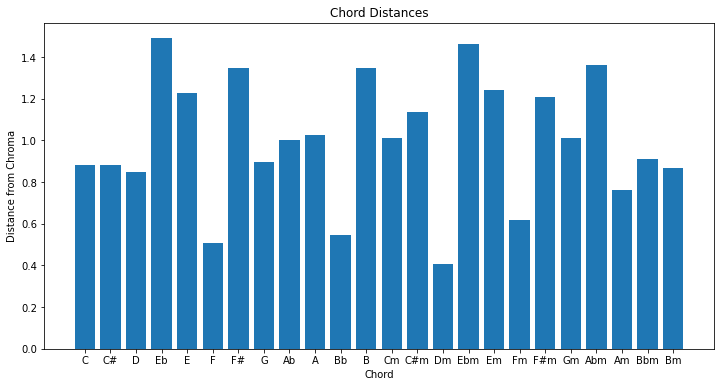


Closest template:  Dm with distance 0.4086


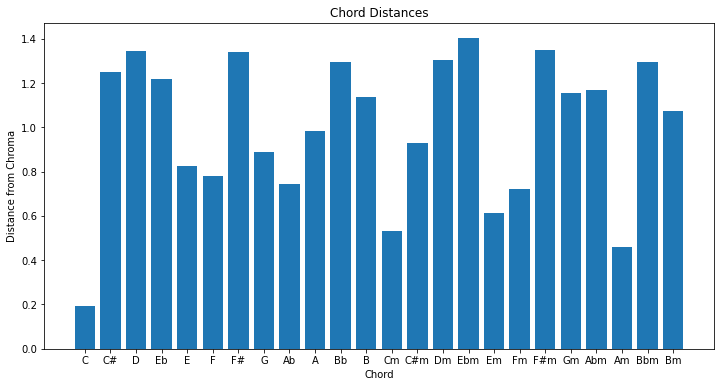


Closest template:  C with distance 0.1914


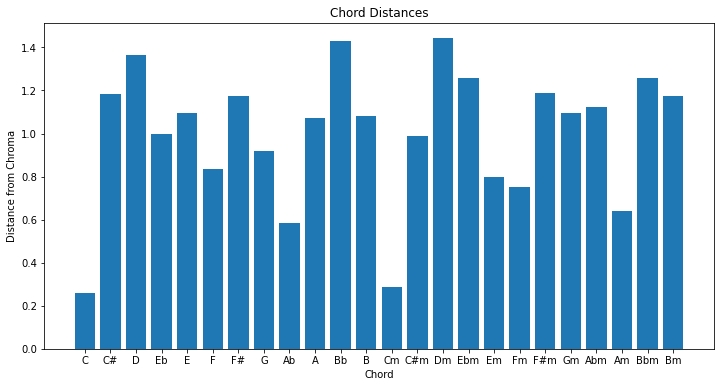


Closest template:  C with distance 0.2605


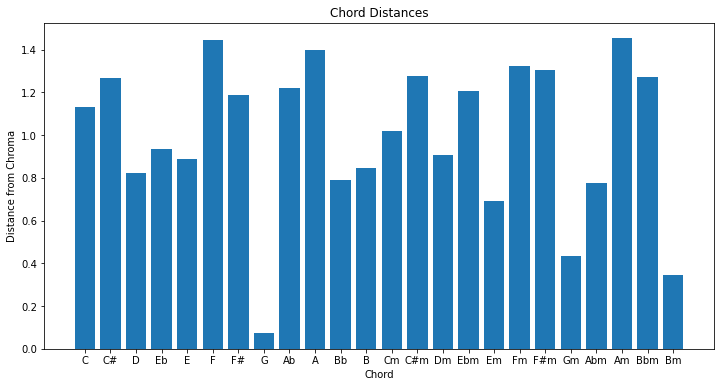


Closest template:  G with distance 0.0727


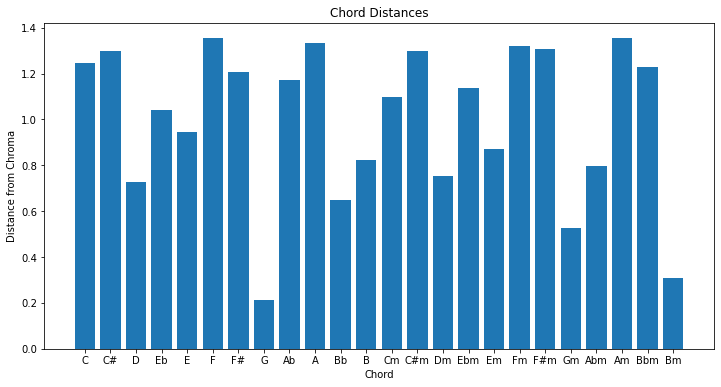


Closest template:  G with distance 0.2115


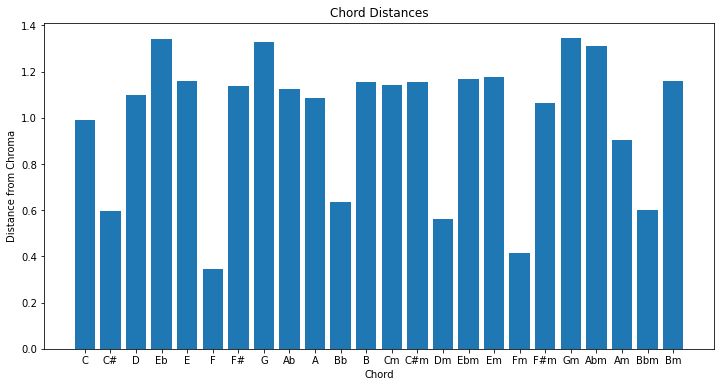


Closest template:  F with distance 0.3438


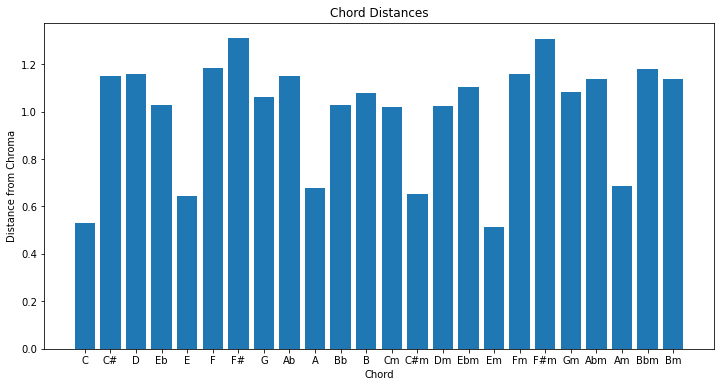


Closest template:  Em with distance 0.5143


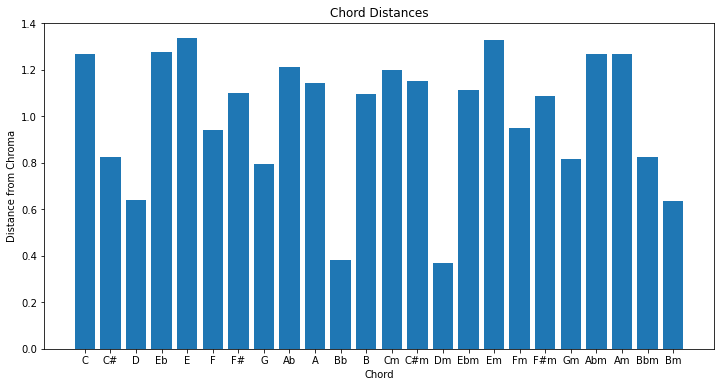


Closest template:  Dm with distance 0.3689


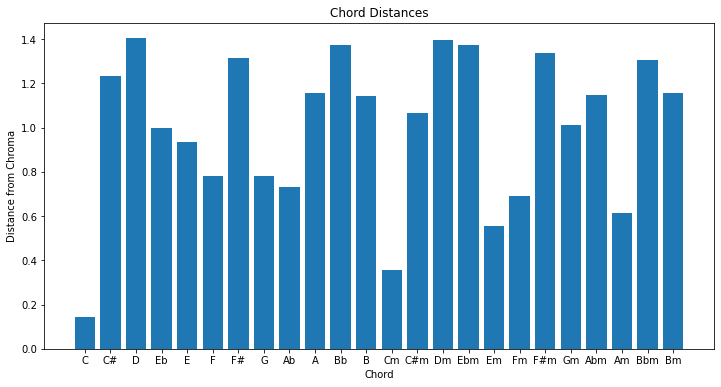


Closest template:  C with distance 0.1416



In [67]:
# print out chord for each beat

# print('| ',end='')
for b in beats:

    ch = get_chroma(X[b:(b+18432)])
    #print("Chroma", ch,"\n")

    (chord_name,dist) = apply_chord_templates(ch,dist="CD")
    
#     print(chord_name+' | ',end='')
print()

    | C | C | Cm | G | Am | Am C | F | F | C | C | G | G | F | Em Dm | C |

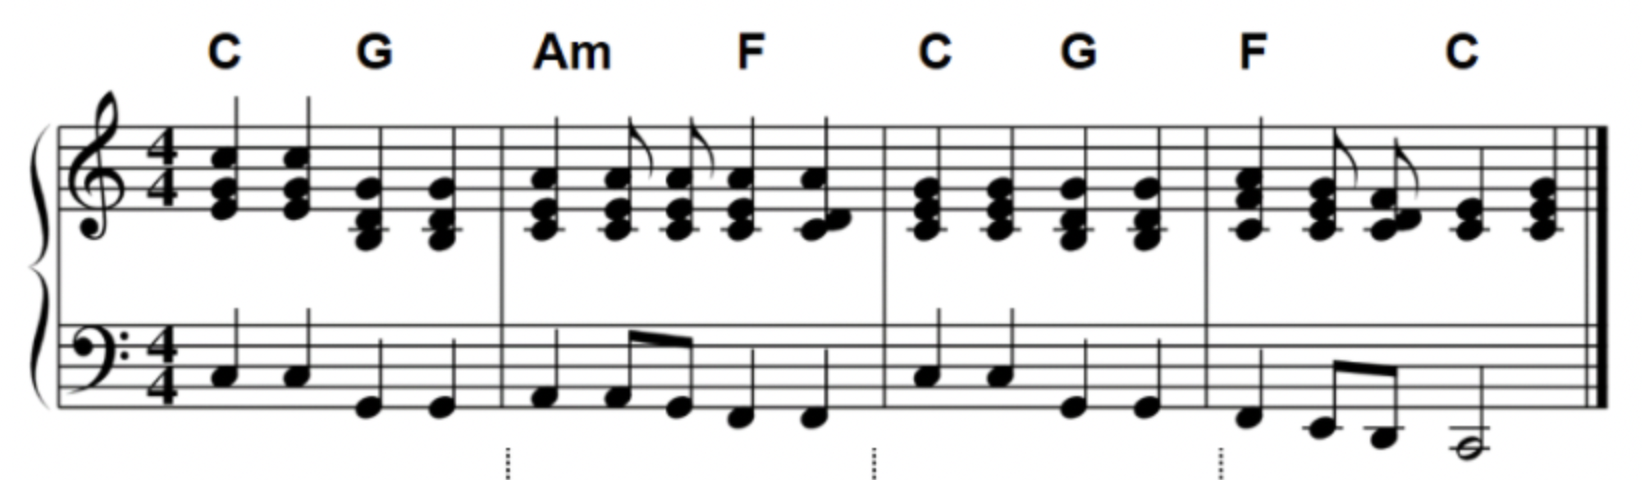